In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision

In [2]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

In [3]:
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5

In [7]:
directory='../input/celeba-dataset/img_align_celeba'

In [20]:
dataset = dset.ImageFolder(root=directory,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [26]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu' )

In [21]:
dataiter=iter(dataloader)
images,labels=next(dataiter)
print(images.shape)
print(np.transpose(images[1],(1,2,0)).shape)
print(labels.shape)

torch.Size([128, 3, 64, 64])
torch.Size([64, 64, 3])
torch.Size([128])


In [22]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data,0.0,0.02)




In [23]:
#Generator
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
          # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
  def forward(self,x):
    return self.main(x)

In [28]:
netG=Generator().to(device)
initialize_weights(netG)

In [24]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
  def forward(self,x):
    return self.main(x)

In [27]:
netD=Discriminator().to(device)
initialize_weights(netD)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [29]:
criterion=nn.BCELoss()
fixed_noise=torch.randn(64,nz,1,1,device=device)
real_label=1
fake_label=0
optimizerD=optim.Adam(netD.parameters(),lr=lr,betas=(beta1,0.999))
optimizerG=optim.Adam(netG.parameters(),lr=lr,betas=(beta1,0.999))

In [30]:
img_list = []
G_losses = []
D_losses = []
iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]tLoss_D: %.4ftLoss_G: %.4ftD(x): %.4ftD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

Starting Training Loop...
[0/5][0/1583]tLoss_D: 1.3799tLoss_G: 0.7035tD(x): 0.5051tD(G(z)): 0.5019 / 0.4949
[0/5][50/1583]tLoss_D: 0.0964tLoss_G: 3.0073tD(x): 0.9604tD(G(z)): 0.0543 / 0.0494
[0/5][100/1583]tLoss_D: 0.0271tLoss_G: 4.2439tD(x): 0.9892tD(G(z)): 0.0160 / 0.0144
[0/5][150/1583]tLoss_D: 0.0906tLoss_G: 4.3956tD(x): 0.9703tD(G(z)): 0.0582 / 0.0124
[0/5][200/1583]tLoss_D: 0.0479tLoss_G: 4.4060tD(x): 0.9794tD(G(z)): 0.0264 / 0.0123
[0/5][250/1583]tLoss_D: 0.0227tLoss_G: 5.2002tD(x): 0.9944tD(G(z)): 0.0169 / 0.0056
[0/5][300/1583]tLoss_D: 0.1157tLoss_G: 5.1864tD(x): 0.9682tD(G(z)): 0.0775 / 0.0063
[0/5][350/1583]tLoss_D: 0.6677tLoss_G: 2.9500tD(x): 0.6371tD(G(z)): 0.0609 / 0.0643
[0/5][400/1583]tLoss_D: 0.3581tLoss_G: 3.8662tD(x): 0.7737tD(G(z)): 0.0442 / 0.0220
[0/5][450/1583]tLoss_D: 0.5277tLoss_G: 2.5913tD(x): 0.8084tD(G(z)): 0.2511 / 0.0829
[0/5][500/1583]tLoss_D: 1.0114tLoss_G: 2.4691tD(x): 0.4223tD(G(z)): 0.0224 / 0.1014
[0/5][550/1583]tLoss_D: 0.6138tLoss_G: 3.7967tD(x): 0

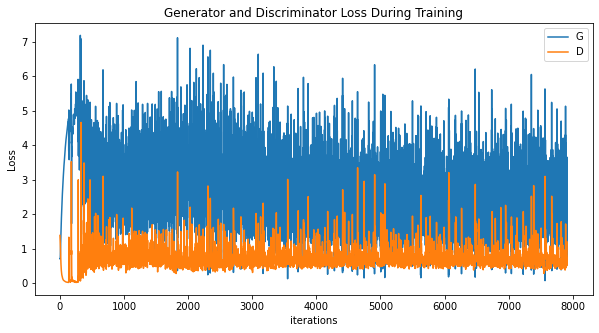

In [31]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

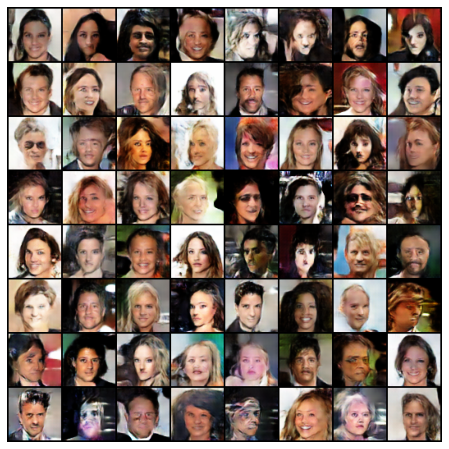

In [39]:
fig=plt.figure(figsize=(8,8))
plt.axis('off')
ims=[[plt.imshow(np.transpose(i,(1,2,0)),animated=True)]for i  in img_list]
ani=animation.ArtistAnimation(fig,ims,interval=1000,repeat_delay=1000,blit=True)
HTML(ani.to_jshtml())
f=r'./an.gif'
writergif = animation.PillowWriter(fps=5) 
ani.save(f, writer=writergif)


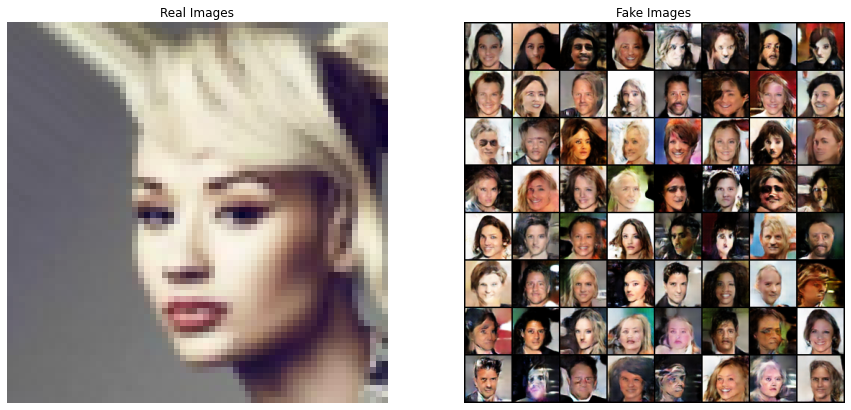

In [34]:
dataiter=iter(dataloader)
real_batch,labels=next(dataiter)

# Plot the real images

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)

plt.axis("off")

plt.title("Real Images")

plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


# Plot the fake images from the last epoch

plt.subplot(1,2,2)

plt.axis("off")

plt.title("Fake Images")

plt.imshow(np.transpose(img_list[-1],(1,2,0)))

plt.show()